# Temperature Prediction

## Objective
Predict the **temperature** based on humidity data.


## Dataset Overview
The dataset contains hourly or daily readings of humidity and temperature.


## Workflow
1. Load the dataset  
2. Explore and clean the data  
3. Train a regression model  
4. Evaluate predictions


In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn essentials
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv("humidity.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701548 entries, 0 to 701547
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    701548 non-null  int64  
 1   lat          701548 non-null  float64
 2   lon          701548 non-null  float64
 3   pressure     701548 non-null  float64
 4   temperature  701548 non-null  float64
 5   humidity     701548 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 32.1 MB


,sensor_id,lat,lon,pressure,temperature,humidity
0,2266,42.738,23.272,95270.27,23.46,62.48
1,2292,42.663,23.273,94355.83,23.06,59.46
2,3096,42.700,23.360,95155.81,26.53,44.38
3,3428,42.624,23.406,94679.57,28.34,38.28
4,3472,42.669,23.318,94327.88,26.31,46.37


## Exploratory Data Analysis


In [3]:
df.isnull().any().any()

False

> No missing values

In [4]:
df.duplicated().any()

True

In [5]:
df[df.duplicated()]

,sensor_id,lat,lon,pressure,temperature,humidity
22745,3558,42.671,23.364,94664.77,23.93,56.79
24090,3092,42.666,23.284,94406.69,22.68,0.00
61634,2607,42.660,23.319,94767.27,15.54,83.29
62650,3836,42.702,23.371,95632.28,17.18,81.73
141868,1954,42.704,23.354,95411.62,30.93,30.85
...,...,...,...,...,...,...
701327,2040,42.686,23.351,117638.84,-145.12,100.00
701374,2040,42.686,23.351,117638.84,-145.12,100.00
701414,2040,42.686,23.351,117638.84,-145.12,100.00
701461,2040,42.686,23.351,117638.84,-145.12,100.00


In [6]:
df= df.drop_duplicates()

In [7]:
corr_matrix = df.corr(numeric_only=True)

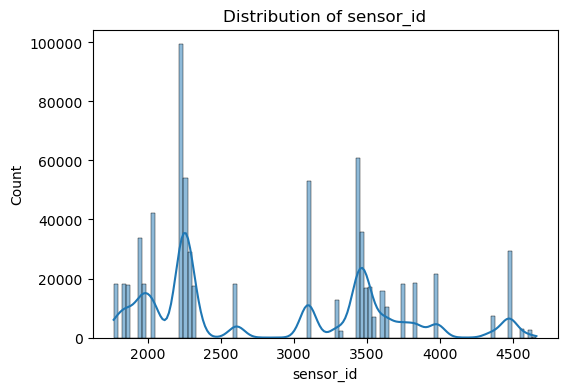

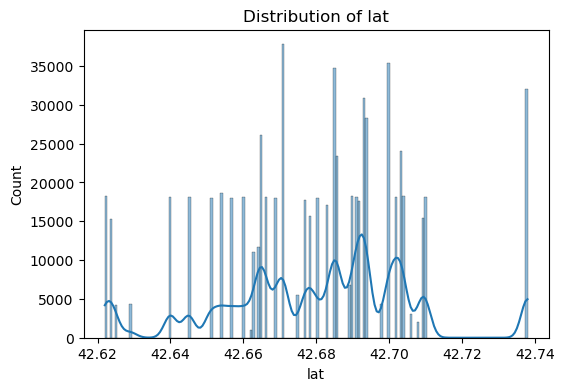

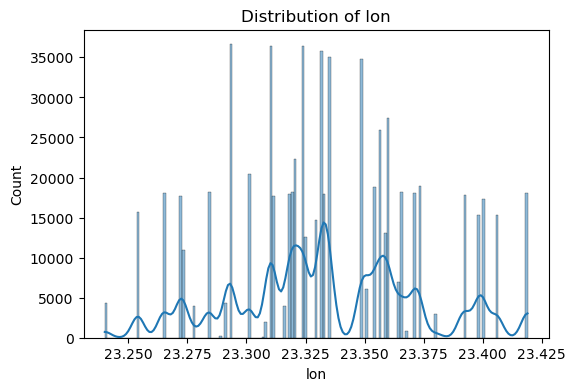

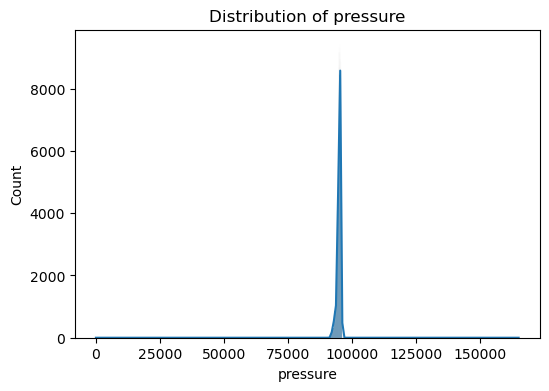

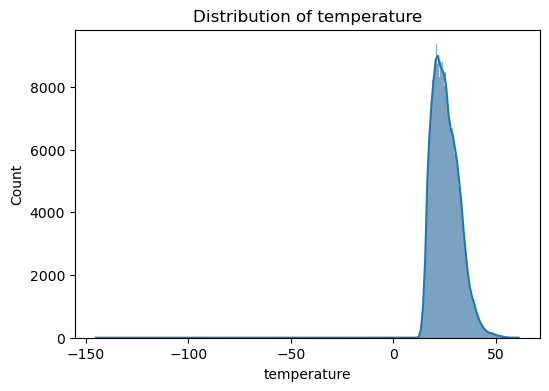

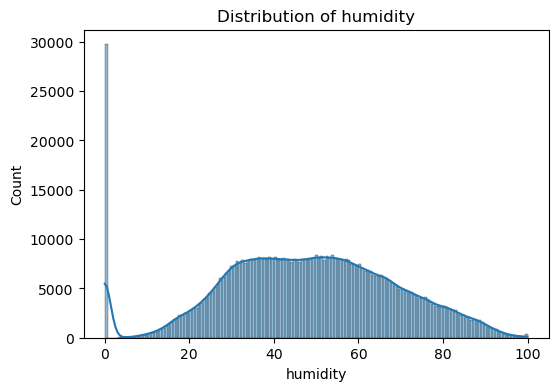

In [8]:
# Plot distributions for numeric columns
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

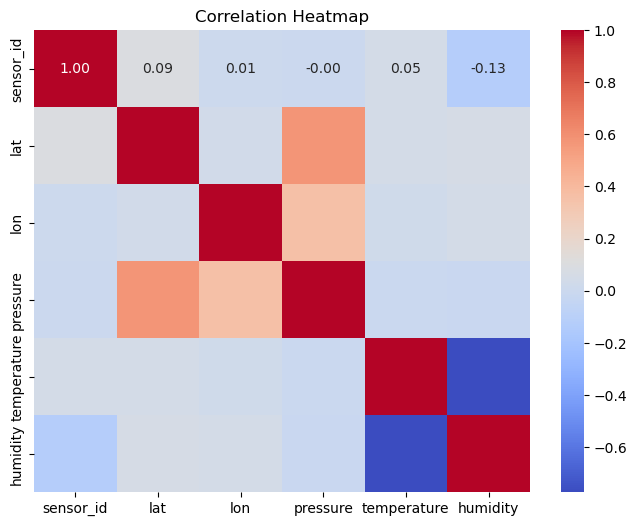

In [9]:
# Heatmap for correlations
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

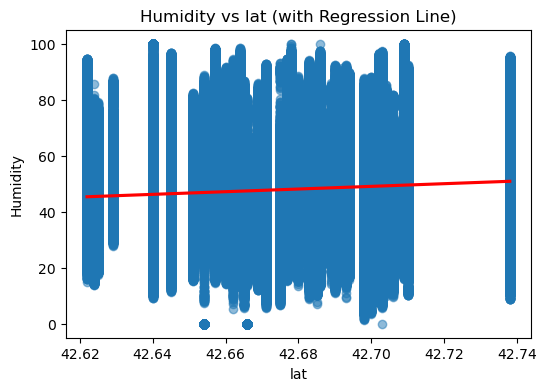

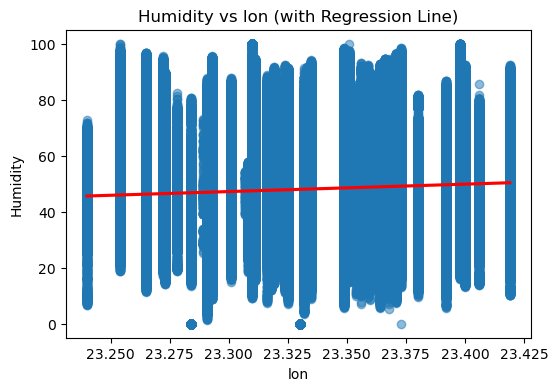

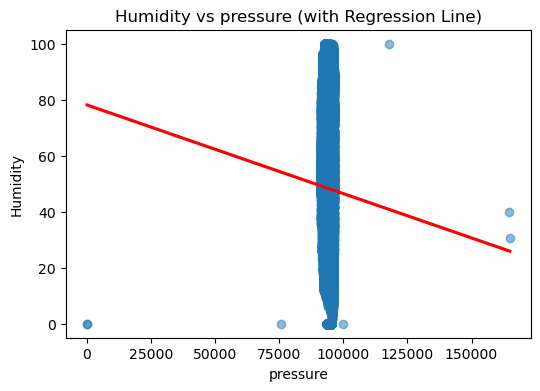

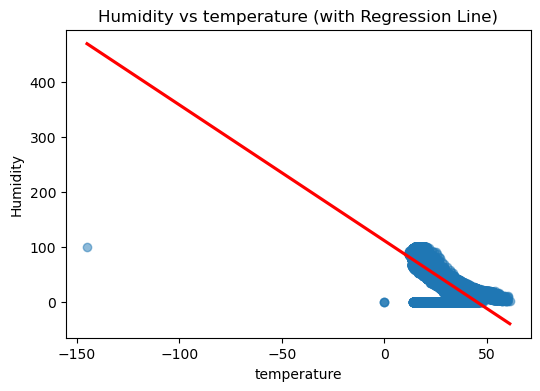

In [10]:
# scatter plots with regression lines
for col in ["lat", "lon", "pressure", "temperature"]:
    plt.figure(figsize=(6,4))
    sns.regplot(data=df, x=col, y="humidity", scatter_kws={'alpha':0.5}, line_kws={"color":"red"}, ci=None)
    plt.title(f"Humidity vs {col} (with Regression Line)")
    plt.xlabel(col)
    plt.ylabel("Humidity")
    plt.show()

> Latitude & Longitude → almost flat regression lines, confirming no strong effect on humidity.

> Pressure vs Humidity → slight positive slope (higher pressure, slightly higher humidity).

> Temperature vs Humidity → strong negative slope (as temperature rises, humidity decreases).

In [11]:
for col in ["pressure", "temperature", "humidity"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

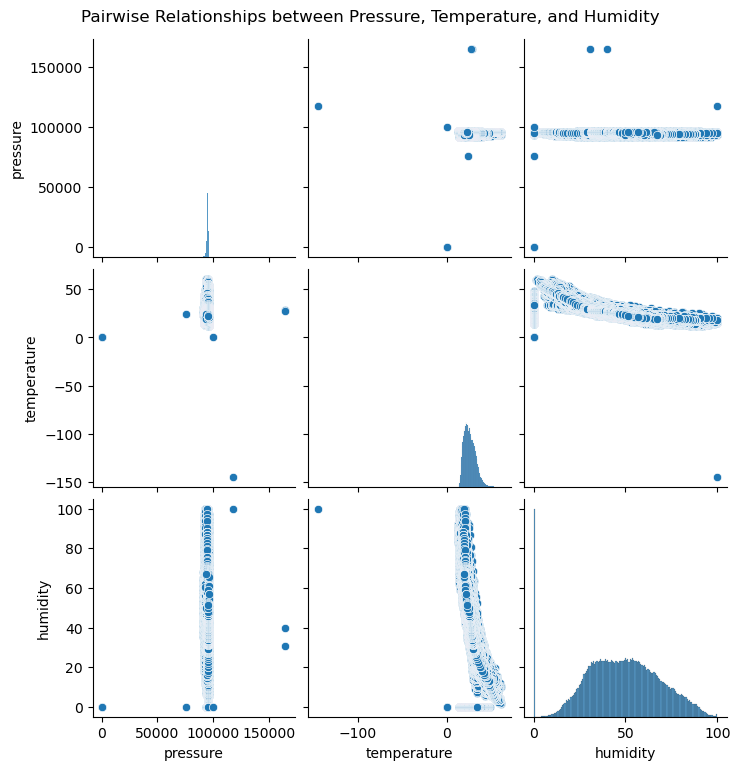

In [12]:
sns.pairplot(df[["pressure", "temperature", "humidity"]].dropna(), diag_kind="hist")
plt.suptitle("Pairwise Relationships between Pressure, Temperature, and Humidity", y=1.02)
plt.show()

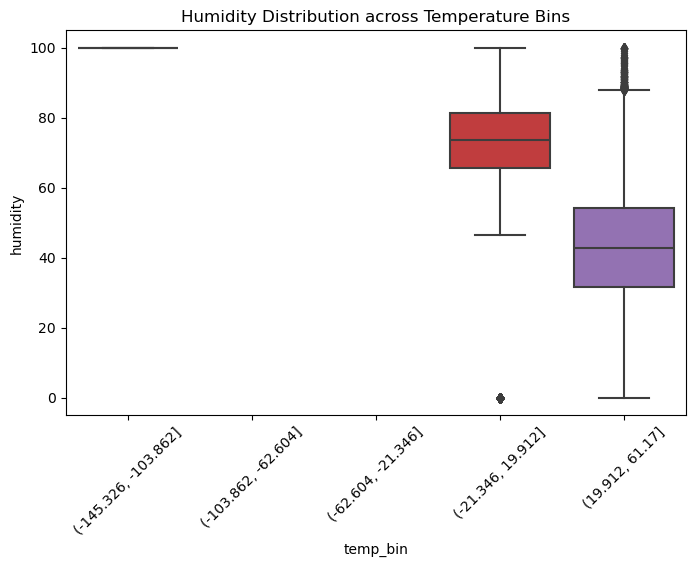

In [13]:
## Boxplots: Humidity distribution across temperature bins
df["temp_bin"] = pd.cut(df["temperature"], bins=5)

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="temp_bin", y="humidity")
plt.xticks(rotation=45)
plt.title("Humidity Distribution across Temperature Bins")
plt.show()

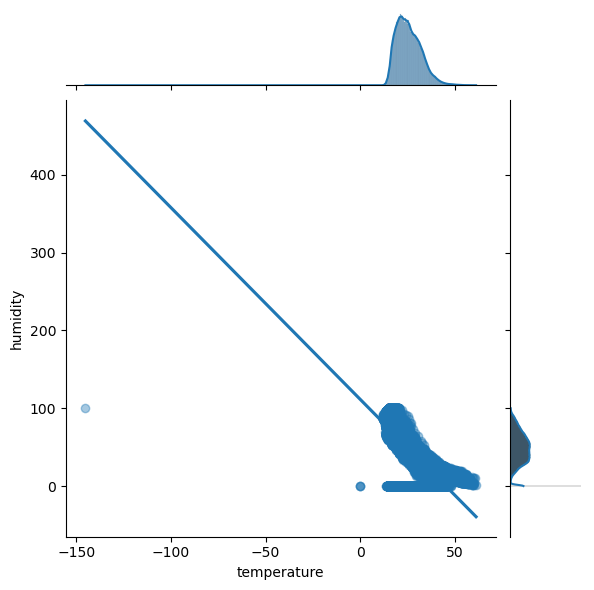

In [14]:
# Jointplot: Temperature vs Humidity with regression line
sns.jointplot(data=df, x="temperature", y="humidity", kind="reg", height=6, scatter_kws={'alpha':0.4})
plt.show()

## Data Preprocessing

In [15]:
# Drop missing values
df = df.dropna().reset_index(drop=True)

In [16]:
FEATURE_COLS = ["lat", "lon", "pressure", "temperature"]
TARGET_COL = "humidity"

In [17]:
X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].copy()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training

In [20]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [21]:
# For Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

print(f"Linear Regression -> R²: {r2_lr:.2f}, MSE: {mse_lr:.2f}, RMSE: {rmse_lr:.2f}")

Linear Regression -> R²: 0.63, MSE: 157.23, RMSE: 12.54


In [22]:
# Parameter grid for Linear Regression
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False],
    "copy_X": [True, False],
    "n_jobs": [None, -1]
}

# GridSearchCV
grid = GridSearchCV(lr, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False], 'n_jobs': [None, -1],
                         'positive': [True, False]},
             scoring='r2', verbose=2)

In [23]:
print("Best Parameters:", grid.best_params_)
print("Best CV R²:", round(grid.best_score_, 4))

Best Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Best CV R²: 0.6262


In [24]:
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test)

In [25]:
# Cross-validation results as DataFrame
cv_results = pd.DataFrame(grid.cv_results_)
cv_results = cv_results[[
    "params", "mean_test_score", "std_test_score", "rank_test_score"
]].sort_values(by="rank_test_score")

print("\n Top 5 Cross-validation results:")
print(cv_results.head(5)) 


 Top 5 Cross-validation results:
                                               params  mean_test_score  \
1   {'copy_X': True, 'fit_intercept': True, 'n_job...         0.626175   
3   {'copy_X': True, 'fit_intercept': True, 'n_job...         0.626175   
9   {'copy_X': False, 'fit_intercept': True, 'n_jo...         0.626175   
11  {'copy_X': False, 'fit_intercept': True, 'n_jo...         0.626175   
0   {'copy_X': True, 'fit_intercept': True, 'n_job...         0.005845   

    std_test_score  rank_test_score  
1         0.002024                1  
3         0.002024                1  
9         0.002024                1  
11        0.002024                1  
0         0.000362                5  


## Evaluation


In [26]:
# For Linear Regression
r2_lr = r2_score(y_test, y_pred)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = mean_squared_error(y_test, y_pred, squared=False)

print(f"Linear Regression -> R²: {r2_lr:.3f}, MSE: {mse_lr:.3f}, RMSE: {rmse_lr:.3f}")

Linear Regression -> R²: 0.629, MSE: 157.234, RMSE: 12.539


## Conclusion
- A simple linear regression model was used to predict temperature from humidity.  
- Consider using polynomial regression or time-series models for more complex patterns.


## Polynomial Regression

In [27]:
# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("reg", LinearRegression())
])

# GridSearchCV
param_grid = {
    "poly__degree": [1, 2, 3],
    "reg__fit_intercept": [True, False],
    "reg__positive": [False, True]
}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

# Results
print("Best params:", grid.best_params_)
print("Best CV R²:", round(grid.best_score_, 4))
y_pred = grid.best_estimator_.predict(X_test)
print("Test R²:", round(r2_score(y_test, y_pred), 4))
print("Test RMSE:", round(mean_squared_error(y_test, y_pred, squared=False), 4))

Best params: {'poly__degree': 2, 'reg__fit_intercept': True, 'reg__positive': False}
Best CV R²: 0.6429
Test R²: 0.6721
Test RMSE: 11.7939
